In [42]:
import mhcflurry, seaborn, numpy, pandas, pickle, sklearn, collections, scipy, time
import mhcflurry.dataset
import fancyimpute, locale
from matplotlib import pyplot


import sklearn.metrics
import sklearn.cross_validation
%matplotlib inline


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

In [13]:
max_ic50 = 50000
data_dir = "../data/"

In [14]:
all_train_data = mhcflurry.dataset.Dataset.from_csv(data_dir + "bdata.2009.mhci.public.1.txt")

In [15]:
def make_scores(ic50_y, ic50_y_pred, sample_weight=None, threshold_nm=500):     
    y_pred = mhcflurry.regression_target.ic50_to_regression_target(ic50_y_pred, max_ic50)
    try:
        auc = sklearn.metrics.roc_auc_score(ic50_y <= threshold_nm, y_pred, sample_weight=sample_weight)
    except ValueError:
        auc = numpy.nan
    try:
        f1 = sklearn.metrics.f1_score(ic50_y <= threshold_nm, ic50_y_pred <= threshold_nm, sample_weight=sample_weight)
    except ValueError:
        f1 = numpy.nan
    try:
        tau = scipy.stats.kendalltau(ic50_y_pred, ic50_y)[0]
    except ValueError:
        tau = numpy.nan
    
    return dict(
        auc=auc,
        f1=f1,
        tau=tau,
    )  

In [16]:
models = pandas.read_csv("../data/validation_models.csv", converters={'layer_sizes': eval})
models["layer_size"] = [x[0] for x in models.layer_sizes]
del models["activation"]
models

,dropout_probability,embedding_output_dim,impute,layer_sizes,layer_size
0,0.0,32,False,[64],64
1,0.0,8,False,[4],4
2,0.5,32,False,[64],64
3,0.5,8,False,[4],4
4,0.0,32,True,[64],64
5,0.0,8,True,[4],4
6,0.5,32,True,[64],64
7,0.5,8,True,[4],4


In [17]:
def name_model(row):
    size = "big" if row.embedding_output_dim == 32 else "small"
    pieces = [size]
    if row.dropout_probability > 0:
        pieces.append("dropout")
    if row.impute:
        pieces.append("impute")
    return " ".join(pieces)

models["num"] = models.index
models["name"] = [name_model(row) for (_, row) in models.iterrows()]
models

,dropout_probability,embedding_output_dim,impute,layer_sizes,layer_size,num,name
0,0.0,32,False,[64],64,0,big
1,0.0,8,False,[4],4,1,small
2,0.5,32,False,[64],64,2,big dropout
3,0.5,8,False,[4],4,3,small dropout
4,0.0,32,True,[64],64,4,big impute
5,0.0,8,True,[4],4,5,small impute
6,0.5,32,True,[64],64,6,big dropout impute
7,0.5,8,True,[4],4,7,small dropout impute


In [18]:
model_groups = models.groupby("name").num.unique()
model_groups

name
big                     [0]
big dropout             [2]
big dropout impute      [6]
big impute              [4]
small                   [1]
small dropout           [3]
small dropout impute    [7]
small impute            [5]
Name: num, dtype: object

In [19]:
validation_df_with_mhcflurry_results = pandas.read_csv("../data/validation_predictions_full.csv")
validation_df_with_mhcflurry_results

,allele,peptide,length,meas,netmhc,netmhcpan,smmpmbec_cpp,mhcflurry 0,mhcflurry 1,mhcflurry 2,mhcflurry 3,mhcflurry 4,mhcflurry 5,mhcflurry 6,mhcflurry 7
0,H-2-DB,AAACNVATA,9,657.657837,154.881662,711.213514,438.530698,5.451339,101.031088,820.899047,869.601741,59.834101,27.943191,608.394258,811.199864
1,H-2-DB,AAFEFVYV,8,30831.879502,6456.542290,785.235635,10351.421667,29611.681275,10194.929401,13355.273001,24772.895203,30971.969221,11948.433480,11875.604773,23080.234754
2,H-2-DB,AAFVNDYSL,9,77.446180,17.458222,7.516229,28.054336,13.543497,75.988225,32.385539,179.998789,315.922174,39.496692,19.949449,179.248142
3,H-2-DB,AAIANQAAV,9,1.999862,9.638290,9.749896,25.703958,5.779730,10.814566,7.445489,83.166802,2.613762,43.592036,5.861501,74.532864
4,H-2-DB,AAIANQAVV,9,1.517050,8.550667,8.336812,28.773984,1.740462,4.376349,5.543891,79.100063,4.624470,7.253820,4.515577,69.159665
5,H-2-DB,AAIENYVRF,9,37.844258,252.348077,114.815362,187.068214,22.095282,50.841470,241.358596,559.872375,550.332342,19.113564,287.854885,525.939006
6,H-2-DB,AAINFITTM,9,3.155005,199.986187,389.045145,200.909281,28.622502,24.963412,178.902143,343.282060,18.001538,227.662890,110.146283,151.060043
7,H-2-DB,AAIPAPPPI,9,3243.396173,1059.253725,493.173804,295.120923,1296.377555,857.209411,488.717022,164.852471,4100.242979,557.652976,469.690670,116.277820
8,H-2-DB,AAKLNRPPL,9,654.636174,66.374307,77.268059,38.459178,174.309147,45.290250,130.499676,211.171559,23.736367,34.675442,131.878046,175.714103
9,H-2-DB,AALDMVDAL,9,229.614865,547.015963,597.035287,225.423921,6239.534375,4963.755498,720.436304,503.218493,435.649890,1038.488658,651.353328,371.779976


In [20]:
# Extend with ensemble predictions
all_indices = sorted(set.union(*[set(indices) for (name, indices) in model_groups.iteritems()]))
all_indices_impute = sorted(
    set.union(*[set(indices) for (name, indices) in model_groups.iteritems() if 'impute' in name]))
all_indices_not_impute = sorted(
    set.union(*[set(indices) for (name, indices) in model_groups.iteritems() if 'impute' not in name]))

for (name, indices) in list(model_groups.iteritems()) + [("all", all_indices), ("all impute", all_indices_impute), ("all not impute", all_indices_not_impute)]:
    validation_df_with_mhcflurry_results["mhcflurry ensemble %s" % name] = \
        scipy.stats.mstats.gmean(
            validation_df_with_mhcflurry_results[["mhcflurry %d" % i for i in indices]],
            axis=1)

validation_df_with_mhcflurry_results

,allele,peptide,length,meas,netmhc,netmhcpan,smmpmbec_cpp,mhcflurry 0,mhcflurry 1,mhcflurry 2,...,mhcflurry ensemble big dropout,mhcflurry ensemble big dropout impute,mhcflurry ensemble big impute,mhcflurry ensemble small,mhcflurry ensemble small dropout,mhcflurry ensemble small dropout impute,mhcflurry ensemble small impute,mhcflurry ensemble all,mhcflurry ensemble all impute,mhcflurry ensemble all not impute
0,H-2-DB,AAACNVATA,9,657.657837,154.881662,711.213514,438.530698,5.451339,101.031088,820.899047,...,820.899047,608.394258,59.834101,101.031088,869.601741,811.199864,27.943191,154.485692,169.486237,140.812784
1,H-2-DB,AAFEFVYV,8,30831.879502,6456.542290,785.235635,10351.421667,29611.681275,10194.929401,13355.273001,...,13355.273001,11875.604773,30971.969222,10194.929401,24772.895203,23080.234753,11948.433480,17811.749199,17846.125248,17777.439368
2,H-2-DB,AAFVNDYSL,9,77.446180,17.458222,7.516229,28.054336,13.543497,75.988225,32.385539,...,32.385539,19.949449,315.922174,75.988225,179.998789,179.248142,39.496692,63.599402,81.730019,49.490798
3,H-2-DB,AAIANQAAV,9,1.999862,9.638290,9.749896,25.703958,5.779730,10.814566,7.445489,...,7.445489,5.861501,2.613762,10.814566,83.166802,74.532864,43.592036,14.474338,14.936797,14.026198
4,H-2-DB,AAIANQAVV,9,1.517050,8.550667,8.336812,28.773984,1.740462,4.376349,5.543891,...,5.543891,4.515577,4.624470,4.376349,79.100063,69.159665,7.253820,8.769914,10.116929,7.602247
5,H-2-DB,AAIENYVRF,9,37.844258,252.348077,114.815362,187.068214,22.095282,50.841470,241.358596,...,241.358596,287.854885,550.332342,50.841470,559.872375,525.939006,19.113564,148.908039,199.764781,110.998566
6,H-2-DB,AAINFITTM,9,3.155005,199.986187,389.045145,200.909281,28.622502,24.963412,178.902143,...,178.902143,110.146283,18.001538,24.963412,343.282060,151.060043,227.662890,86.000294,90.872049,81.389719
7,H-2-DB,AAIPAPPPI,9,3243.396173,1059.253725,493.173804,295.120923,1296.377555,857.209411,488.717022,...,488.717022,469.690670,4100.242979,857.209411,164.852471,116.277820,557.652976,570.238747,594.457223,547.006945
8,H-2-DB,AAKLNRPPL,9,654.636174,66.374307,77.268059,38.459178,174.309147,45.290250,130.499676,...,130.499676,131.878046,23.736367,45.290250,211.171559,175.714103,34.675442,89.587650,66.085145,121.448579
9,H-2-DB,AALDMVDAL,9,229.614865,547.015963,597.035287,225.423921,6239.534375,4963.755498,720.436304,...,720.436304,651.353328,435.649890,4963.755498,503.218493,371.779976,1038.488658,1026.229732,575.321362,1830.537737


In [22]:
scores_df = collections.defaultdict(list)
predictors = validation_df_with_mhcflurry_results.columns[4:]
pairs = [
    ("overall", validation_df_with_mhcflurry_results)
] + list(validation_df_with_mhcflurry_results.groupby("allele"))

for (allele, grouped) in pairs:
    scores_df["allele"].append(allele)
    scores_df["test_size"].append(len(grouped.meas))
    for predictor in predictors:
        scores = make_scores(grouped.meas, grouped[predictor])
        for (key, value) in scores.items():
            scores_df["%s_%s" % (predictor, key)].append(value)
            
scores_df = pandas.DataFrame(scores_df)
scores_df["train_size"] = [
        len(all_train_data.groupby_allele_dictionary()[a]) if a != 'overall' else numpy.nan
        for a in scores_df.allele
    ]
scores_df.index = scores_df.allele
scores_df

,allele,mhcflurry 0_auc,mhcflurry 0_f1,mhcflurry 0_tau,mhcflurry 1_auc,mhcflurry 1_f1,mhcflurry 1_tau,mhcflurry 2_auc,mhcflurry 2_f1,mhcflurry 2_tau,...,netmhc_f1,netmhc_tau,netmhcpan_auc,netmhcpan_f1,netmhcpan_tau,smmpmbec_cpp_auc,smmpmbec_cpp_f1,smmpmbec_cpp_tau,test_size,train_size
allele,,,,,,,,,,,,,,,,,,,,,
overall,overall,0.882928,0.704518,0.496251,0.918006,0.780544,0.561266,0.929080,0.787132,0.571978,...,0.800909,0.582258,0.932924,0.793170,0.579586,0.919208,0.784295,0.561996,27680,NaN
H-2-DB,H-2-DB,0.848124,0.535433,0.511345,0.885038,0.596078,0.580237,0.907967,0.546296,0.625583,...,0.621212,0.600337,0.874574,0.577236,0.574262,0.884187,0.628571,0.571252,564,3216
H-2-KB,H-2-KB,0.849000,0.762565,0.471307,0.895286,0.806228,0.586440,0.909416,0.836806,0.587509,...,0.813675,0.573199,0.825565,0.665354,0.486836,0.915994,0.859967,0.589218,558,3407
H-2-KD,H-2-KD,0.763398,0.557143,0.342118,0.772275,0.562963,0.352598,0.786212,0.592593,0.368319,...,0.657718,0.403275,0.819189,0.645570,0.390333,0.753692,0.538462,0.365247,229,452
HLA-A0101,HLA-A0101,0.849094,0.531532,0.409243,0.910766,0.610329,0.508191,0.915757,0.592179,0.521964,...,0.619565,0.524866,0.894895,0.594286,0.498767,0.832665,0.437811,0.428064,696,3725
HLA-A0201,HLA-A0201,0.854361,0.784367,0.488418,0.927671,0.876843,0.619872,0.930293,0.883262,0.624985,...,0.884336,0.635498,0.930479,0.880963,0.637338,0.927358,0.885121,0.626224,2126,9565
HLA-A0202,HLA-A0202,0.767461,0.639175,0.422552,0.874446,0.719101,0.596025,0.895233,0.769231,0.605748,...,0.755556,0.627143,0.898697,0.769231,0.624280,0.882206,0.727273,0.606938,126,3919
HLA-A0203,HLA-A0203,0.923881,0.884058,0.465846,0.972561,0.939645,0.580955,0.979134,0.954869,0.592506,...,0.948626,0.586911,0.974158,0.944578,0.591463,0.972885,0.946746,0.583908,651,5542
HLA-A0206,HLA-A0206,0.829841,0.778351,0.415579,0.900923,0.866911,0.510937,0.906767,0.869779,0.528590,...,0.872902,0.543184,0.910796,0.866258,0.535067,0.904317,0.878282,0.527571,682,4827


In [23]:
print(" ".join(scores_df.index))
print(scores_df.shape)

overall H-2-DB H-2-KB H-2-KD HLA-A0101 HLA-A0201 HLA-A0202 HLA-A0203 HLA-A0206 HLA-A0301 HLA-A1101 HLA-A2301 HLA-A2402 HLA-A2501 HLA-A2601 HLA-A2602 HLA-A2603 HLA-A2902 HLA-A3001 HLA-A3002 HLA-A3101 HLA-A3201 HLA-A3301 HLA-A6801 HLA-A6802 HLA-A6901 HLA-A8001 HLA-B0702 HLA-B0801 HLA-B0802 HLA-B0803 HLA-B1501 HLA-B1503 HLA-B1509 HLA-B1517 HLA-B1801 HLA-B2703 HLA-B2705 HLA-B3501 HLA-B3801 HLA-B3901 HLA-B4001 HLA-B4002 HLA-B4402 HLA-B4403 HLA-B4501 HLA-B4601 HLA-B5101 HLA-B5301 HLA-B5401 HLA-B5701 HLA-B5801 Mamu-A01 Mamu-A02
(54, 69)


In [25]:
print_full(scores_df.ix["overall"].sort(inplace=False, ascending=False))

allele                                           overall
test_size                                          27680
netmhcpan_auc                                  0.9329235
netmhc_auc                                     0.9299468
mhcflurry ensemble big dropout_auc               0.92908
mhcflurry 2_auc                                  0.92908
mhcflurry ensemble big dropout impute_auc      0.9287027
mhcflurry 6_auc                                0.9287027
mhcflurry ensemble all_auc                     0.9275826
mhcflurry ensemble all impute_auc              0.9268115
mhcflurry ensemble all not impute_auc          0.9249937
mhcflurry ensemble small impute_auc            0.9205328
mhcflurry 5_auc                                0.9205328
smmpmbec_cpp_auc                               0.9192085
mhcflurry ensemble small_auc                   0.9180064
mhcflurry 1_auc                                0.9180064
mhcflurry 7_auc                                0.9176498
mhcflurry ensemble small dropou

In [26]:
print_full(scores_df.ix[(scores_df.index != "overall") & (scores_df.train_size >= 1000)].mean(0).sort(inplace=False, ascending=False))

train_size                                     3131.285714
test_size                                       605.371429
mhcflurry 6_auc                                   0.903385
mhcflurry ensemble big dropout impute_auc         0.903385
mhcflurry ensemble all_auc                        0.902820
mhcflurry ensemble big dropout_auc                0.902490
mhcflurry 2_auc                                   0.902490
mhcflurry ensemble all impute_auc                 0.900867
netmhcpan_auc                                     0.900643
netmhc_auc                                        0.900374
mhcflurry ensemble all not impute_auc             0.899897
mhcflurry 3_auc                                   0.894749
mhcflurry ensemble small dropout_auc              0.894749
mhcflurry 5_auc                                   0.893936
mhcflurry ensemble small impute_auc               0.893936
mhcflurry ensemble small dropout impute_auc       0.893547
mhcflurry 7_auc                                   0.8935

In [31]:
print_full(scores_df.ix[(scores_df.index != "overall") & (scores_df.train_size < 1000)].mean(0).sort(inplace=False, ascending=False))

train_size                                     565.888889
test_size                                      360.666667
netmhcpan_auc                                    0.936087
netmhc_auc                                       0.926065
mhcflurry 6_auc                                  0.914555
mhcflurry ensemble big dropout impute_auc        0.914555
mhcflurry ensemble all_auc                       0.913816
mhcflurry 2_auc                                  0.913501
mhcflurry ensemble big dropout_auc               0.913501
mhcflurry ensemble all impute_auc                0.912783
mhcflurry ensemble small dropout impute_auc      0.909942
mhcflurry 7_auc                                  0.909942
mhcflurry ensemble all not impute_auc            0.908626
smmpmbec_cpp_auc                                 0.905258
mhcflurry 5_auc                                  0.899864
mhcflurry ensemble small impute_auc              0.899864
mhcflurry 1_auc                                  0.881951
mhcflurry ense

In [28]:
print_full(scores_df.ix[scores_df.index != "overall"].mean(0).sort(inplace=False, ascending=False))

train_size                                     2260.018868
test_size                                       522.264151
netmhcpan_auc                                     0.912458
netmhc_auc                                        0.908938
mhcflurry 6_auc                                   0.907108
mhcflurry ensemble big dropout impute_auc         0.907108
mhcflurry ensemble all_auc                        0.906485
mhcflurry ensemble big dropout_auc                0.906160
mhcflurry 2_auc                                   0.906160
mhcflurry ensemble all impute_auc                 0.904839
mhcflurry ensemble all not impute_auc             0.902807
mhcflurry 7_auc                                   0.899012
mhcflurry ensemble small dropout impute_auc       0.899012
mhcflurry ensemble small impute_auc               0.895912
mhcflurry 5_auc                                   0.895912
smmpmbec_cpp_auc                                  0.893880
mhcflurry ensemble small_auc                      0.8889

(0.75, 1.0)

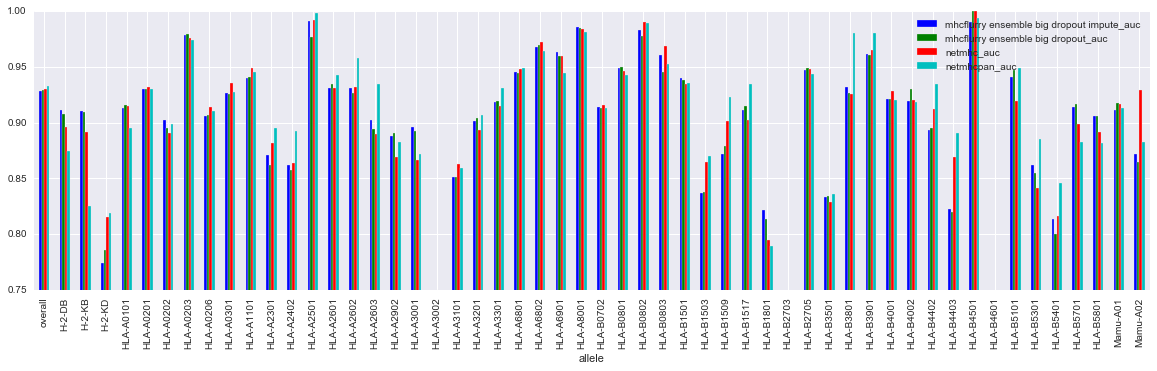

In [54]:
pyplot.figure(figsize=(20,5))
scores_df[[
        "mhcflurry ensemble big dropout impute_auc",
        "mhcflurry ensemble big dropout_auc",
        "netmhc_auc",
        "netmhcpan_auc"
]].plot(kind='bar', ax=pyplot.gca())
pyplot.ylim(ymin=.75, ymax=1.0)

In [50]:
scores_df.plot?

In [ ]:
scores_df[["mhcflurry 6_auc", "netmhc_auc", "netmhcpan_auc"]].plot

In [29]:
scores_df.ix[:, "mhcflurry ensemble small impute_auc"] / scores_df.ix[:, "netmhc_auc"]

allele
overall      0.989877
H-2-DB       0.978362
H-2-KB       1.011331
H-2-KD       0.938034
HLA-A0101    0.983438
HLA-A0201    0.994114
HLA-A0202    0.992062
HLA-A0203    0.996301
HLA-A0206    0.982678
HLA-A0301    0.980282
HLA-A1101    0.986175
HLA-A2301    0.953784
HLA-A2402    0.983222
HLA-A2501    0.994112
HLA-A2601    0.991764
HLA-A2602    0.981905
HLA-A2603    0.996853
HLA-A2902    1.009836
HLA-A3001    1.015944
HLA-A3002    0.950338
HLA-A3101    0.994753
HLA-A3201    1.001196
HLA-A3301    0.986507
HLA-A6801    0.994634
HLA-A6802    0.993701
HLA-A6901    1.000722
HLA-A8001    0.992971
HLA-B0702    0.996995
HLA-B0801    1.000092
HLA-B0802    0.989599
HLA-B0803    0.975523
HLA-B1501    0.994391
HLA-B1503    0.940005
HLA-B1509    0.954165
HLA-B1517    0.995481
HLA-B1801    1.018311
HLA-B2703         NaN
HLA-B2705    0.981630
HLA-B3501    0.990696
HLA-B3801    0.985315
HLA-B3901    0.987083
HLA-B4001    0.971704
HLA-B4002    0.989224
HLA-B4402    0.953884
HLA-B4403    0.895020
HLA

In [30]:
def sub_df(name):
    result = scores_df[[c for c in list(scores_df.columns) if (name + "_") in c]].copy()
    result.columns = [c.split("_")[-1] for c in list(result.columns)]
    return result

d = dict((name, sub_df(name)) for name in predictors)
panel = pandas.Panel(d)
 
panel

<class 'pandas.core.panel.Panel'>
Dimensions: 22 (items) x 54 (major_axis) x 3 (minor_axis)
Items axis: mhcflurry 0 to smmpmbec_cpp
Major_axis axis: overall to Mamu-A02
Minor_axis axis: auc to tau